In [1]:
import sys
sys.path.append('../radiospectra2')
from radiospectra.sources import CallistoSpectrogram 
from Orfees_read import *
from scipy import signal
import pandas as pd
from datetime import timedelta

the Orfees methods are imported....


In [2]:
# def convert_ms_to_date(ecallisto):
#     """
#     Convert the time axis from milliseconds to a date format
# 
#     :return: A list of dates
#     """
#     start_time_str = f"{ecallisto.date_obs} {ecallisto.time_start_obs}"
#     start_time = datetime.datetime.strptime(start_time_str, "%Y-%m-%d %H:%M:%S:%f")
#     print(start_time)
#     list_of_times = []
#     for time_ms in ecallisto.time_axis:
#         time_delta = timedelta(milliseconds=int(time_ms))
#         # print(time_delta)
#         observation_time = start_time + time_delta
#         if observation_time.day != start_time.day:
#              observation_time = observation_time.replace(day=start_time.day)
#         list_of_times.append(observation_time)
#         
#     return list_of_times
# 
# 
# 
# def get_dates_from_orfees(orfees):
#     """
#     Generates a list of datetime objects representing the observation times within an ORFEES dataset.
#     Parameters:
#         orfees: The ORFEES object containing observation start and end times, and the time arrays.
#     Returns:
#         list: A list of datetime objects for each observation time.
#     """
#     start_time_str = f"{orfees.date_obs} {orfees.time_start_obs}"
# 
#     end_time_str = f"{orfees.date_obs} {orfees.time_end_obs}"
# 
#     start_time = datetime.datetime.strptime(start_time_str, "%Y-%m-%d %H:%M:%S:%f")
#     print(start_time)
#     end_time = datetime.datetime.strptime(end_time_str, "%Y-%m-%d %H:%M:%S:%f")
#     print(end_time)
#    
#     # dates = [start_time + timedelta(seconds=int(ts)) for ts in orfees.time_axis]
#     dates = [datetime.datetime.utcfromtimestamp(ts) for ts in orfees.time_axis]
# 
#     
#     return dates


def align_time_axes(orfees, ecallisto):
    # Determine the earliest start time and the latest end time
    orfees_start_time = datetime.datetime.strptime(f"{orfees.date_obs} {orfees.time_start_obs}", "%Y-%m-%d %H:%M:%S:%f")
    ecallisto_start_time = datetime.datetime.strptime(f"{ecallisto.header['DATE-OBS']} {ecallisto.header['TIME-OBS']}", "%Y/%m/%d %H:%M:%S.%f")
    orfees_end_time = datetime.datetime.strptime(f"{orfees.date_obs} {orfees.time_end_obs}", "%Y-%m-%d %H:%M:%S:%f")
    ecallisto_end_time = datetime.datetime.strptime(f"{ecallisto.header['DATE-END']} {ecallisto.header['TIME-END']}", "%Y/%m/%d %H:%M:%S")


    # Find the earliest start time and the latest end time
    start_time = min(orfees_start_time, ecallisto_start_time)
    end_time = max(orfees_end_time, ecallisto_end_time)


    # Generate a common set of time ticks
    total_duration = int((end_time - start_time).total_seconds())

    common_time_ticks = [start_time + datetime.timedelta(seconds=i) for i in range(total_duration)]


    # Filter the time ticks for ORFEES
    orfees_dates = [t for t in common_time_ticks if orfees_start_time <= t <= orfees_end_time]

    # Filter the time ticks for eCallisto
    ecallisto_delta_time = ecallisto.header['CDELT1']

    ecallisto_dates = [t for t in common_time_ticks if ecallisto_start_time <= t <= ecallisto_end_time 
                       and (t - ecallisto_start_time).total_seconds() % ecallisto_delta_time < 1]  



    if not ecallisto_dates:
        print("No eCallisto dates were found. Checking conditions...")
        for t in common_time_ticks:
            if ecallisto_start_time <= t <= ecallisto_end_time:
                diff = (t - ecallisto_start_time).total_seconds()
                remainder = diff % ecallisto_delta_time
                print(f"Time: {t}, Diff: {diff}, Remainder: {remainder}")

    return orfees_dates, ecallisto_dates


In [3]:
# Converts intensity data to decibels using a specified factor
def intensity_to_db(df, factor=0.0386):
    return 10 ** (df * factor)


def get_frequency_range(source, target):
    """
    Extracts the frequency range from the source that matches the target's frequency range.
    
    Parameters:
        source (DataFrame): The source data frame containing frequency data and observations.
        target (DataFrame): The target data frame with the desired frequency range.
    
    Returns:
        tuple: A tuple containing the filtered data, minimum frequency, maximum frequency, and frequency range.
    """
    min_freq = target.freq_axis.min()
    max_freq = target.freq_axis.max()
    mask = (source.freq_axis > min_freq) & (source.freq_axis < max_freq)
    filtered_data = source.data[mask, :]
    
    return filtered_data, min_freq, max_freq, source.freq_axis[mask]

def plot_data_test(orfees, ecallisto):
    orfees_dates, ecallisto_dates = align_time_axes(orfees, ecallisto)
    
    # Assuming get_frequency_range and intensity_to_db are defined and return the correct values
    filtered_orfees_data, min_freq, max_freq, frequency_range = get_frequency_range(orfees, ecallisto)
    filtered_orfees_data = signal.medfilt2d(filtered_orfees_data, kernel_size=3)
    ecallisto_data_db = intensity_to_db(pd.DataFrame(ecallisto.data))
    
    # Determine the time extent for the spectrogram plots
    # This assumes that the dates are equally spaced and cover the duration of the data
    orfees_time_extent = [0, len(orfees_dates) - 1, min_freq, max_freq]
    ecallisto_time_extent = [0, len(ecallisto_dates) - 1, ecallisto.freq_axis.min(), ecallisto.freq_axis.max()]
    
    # Set up the figure and axes
    plt.rcParams["figure.autolayout"] = True
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Plot ORFEES spectrogram
    axs[0, 0].imshow(filtered_orfees_data, extent=orfees_time_extent,vmin=np.nanmin(filtered_orfees_data), vmax=1000, aspect="auto")
    axs[0, 0].set_title("ORFEES")
    axs[0, 0].set_ylabel('Frequency [MHz]')
    
    # Plot eCallisto spectrogram
    axs[1, 0].imshow(ecallisto.data, extent=ecallisto_time_extent, aspect="auto", origin='lower')
    axs[1, 0].set_title("eCallisto_MRO")
    axs[1, 0].set_ylabel('Frequency [MHz]')
    
    # Set the x-ticks for ORFEES and eCallisto to the common time ticks
    # Here we convert datetime objects to strings and set them as x-tick labels
    common_tick_indices = np.linspace(0, len(orfees_dates) - 1, 8, dtype=int)  # Adjust the number of ticks as needed
    common_tick_labels = [orfees_dates[idx].strftime('%H:%M:%S') for idx in common_tick_indices]
    
    for ax in axs[:, 0]:  # Set for both spectrogram subplots
        ax.set_xticks(common_tick_indices)
        ax.set_xticklabels(common_tick_labels, rotation=45, ha='right')

    # Plot intensity for ORFEES

    axs[0, 1].plot(np.nansum(filtered_orfees_data, axis=0))
    axs[0, 1].set_title("ORFEES Intensity")
    axs[0, 1].set_xticks(common_tick_indices)
    axs[0, 1].set_xticklabels(common_tick_labels, rotation=45, ha='right')
    # 
    # Plot intensity for eCallisto
    axs[1, 1].plot(np.nansum(ecallisto_data_db, axis=0))
    axs[1, 1].set_title("eCallisto Intensity")
    axs[1, 1].set_xticks(common_tick_indices)
    axs[1, 1].set_xticklabels(common_tick_labels, rotation=45, ha='right')
    # 
    # for ax in axs[:, 1]:  # Set for both spectrogram subplots
    #     ax.set_xticks(common_tick_indices)
    #     ax.set_xticklabels(common_tick_labels, rotation=45, ha='right')


    plt.tight_layout()
    plt.show()

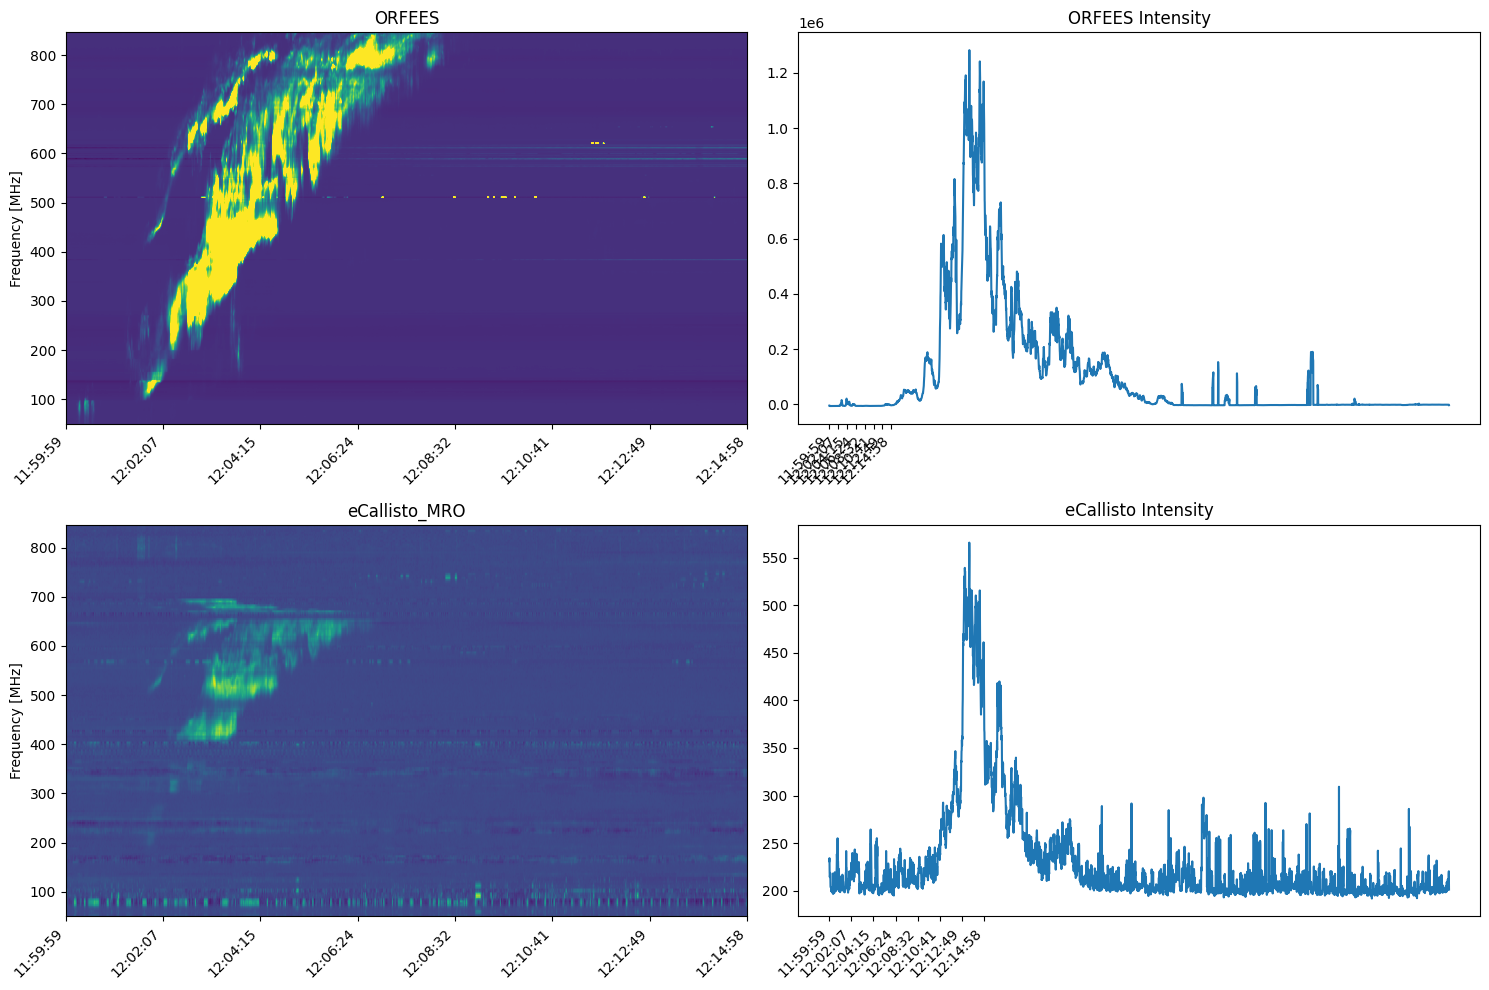

In [4]:
orfees_3 = OrfeesSpectrogram("./orfees_files/int_orf20151104_120000_0.1_test.fts")
orfees_sb = orfees_3.subtract_bg()
spec_3 = CallistoSpectrogram.read("eca_files/MRO_20151104_120000_59 (1).fit.gz")
spec_sb=spec_3.subtract_bg()

plot_data_test(orfees_sb, spec_sb)

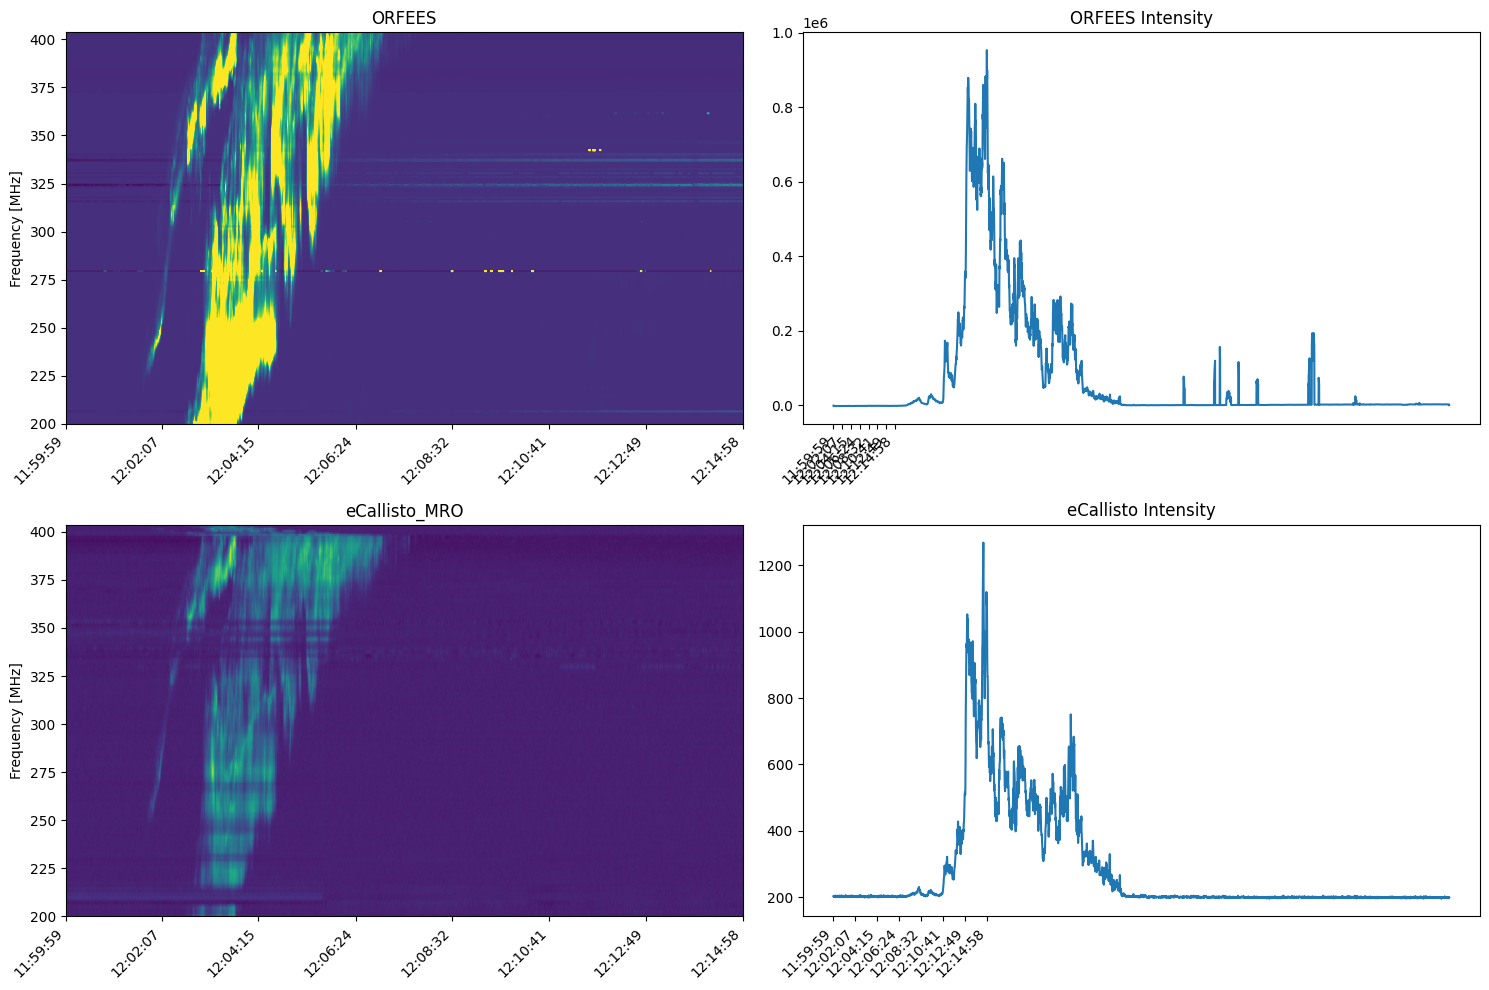

In [5]:
orfees = OrfeesSpectrogram("./orfees_files/int_orf20151104_120000_0.1_test.fts")
orfees_sb = orfees.subtract_bg()
spec = CallistoSpectrogram.read("eca_files/BIR_20151104_120000_03 (1).fit.gz")
spec_sb=spec.subtract_bg()

plot_data_test(orfees_sb, spec_sb)